In [1]:
import sys
# sys.path.insert(0, '../../')
import rasterio
import numpy as np
from pathlib import Path
import rioxarray

In [2]:
import warnings
import time
import os

# RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
#     CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
#     GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
#     AWS_NO_SIGN_REQUEST="YES",
#     GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
#     GDAL_SWATH_SIZE="200000000",
#     VSI_CURL_CACHE_SIZE="200000000",
# )
# os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T

from rasterio.enums import Resampling

# import geopandas as gpd
# import dask_geopandas

# import pystac_client
# import planetary_computer as pc

import shapely.geometry

## Manually extract RGB and NIR patches around north berkeley

In [3]:
from shapely.geometry import Point
berkeley = Point(-122.24055786132824,37.90587960532352)

EPSG:32610
256 420.72165626026947
(3, 256, 420)
torch.Size([3, 256, 256]) <class 'torch.Tensor'>


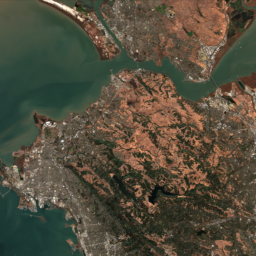

In [5]:


side_length = 50000
side_px=256
image_rgb = None
url_rgb = 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/S/EH/2019/11/21/S2B_MSIL2A_20191121T185659_N0212_R113_T10SEH_20201003T184646.SAFE/GRANULE/L2A_T10SEH_A014153_20191121T190140/IMG_DATA/R10m/T10SEH_20191121T185659_TCI_10m.tif?st=2022-12-05T00%3A56%3A42Z&se=2022-12-06T08%3A56%3A42Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-05T22%3A44%3A02Z&ske=2022-12-12T22%3A44%3A02Z&sks=b&skv=2021-06-08&sig=LcSofYO4vBGvrZ8uuTD3f06WyW66Fyz07n0K8cKr6qg%3D'
url_nir = 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/10/S/EH/2019/11/21/S2B_MSIL2A_20191121T185659_N0212_R113_T10SEH_20201003T184646.SAFE/GRANULE/L2A_T10SEH_A014153_20191121T190140/IMG_DATA/R10m/T10SEH_20191121T185659_B08_10m.tif?st=2022-12-05T00%3A56%3A42Z&se=2022-12-06T08%3A56%3A42Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-05T22%3A44%3A02Z&ske=2022-12-12T22%3A44%3A02Z&sks=b&skv=2021-06-08&sig=LcSofYO4vBGvrZ8uuTD3f06WyW66Fyz07n0K8cKr6qg%3D'


to_pil = T.ToPILImage()

aoi_si = None
aspect_ratio = 1.

buf_perc = 0.1

with rasterio.Env():
    with rasterio.open(url_rgb, "r") as f:
        
        point_geom = rasterio.warp.transform_geom("epsg:4326", f.crs.to_string(), berkeley)
        print(f.crs.to_string())
        #Convert the point to a shape
        point_shape = shapely.geometry.shape(point_geom)
        #Create a square out of it with side_length = buffer*2
        radius = side_length/2 
        mask_shape = point_shape.buffer(radius).envelope
        mask_geom = shapely.geometry.mapping(mask_shape)
        
        # mask_gdf = gpd.GeoDataFrame(geometry=mask_geom, crs=f.crs.to_string())  
        # mask_gdf
        # mask_geom
        # rds = rioxarray.open_rasterio(f) #, masked=True)
        try:

            #Outer crop
            aoi_si = rioxarray.open_rasterio(f).rio.clip([mask_geom], from_disk=True)

            aspect_ratio = aoi_si.shape[2]/aoi_si.shape[1]

            new_height = side_px
            new_width = aspect_ratio * new_height
            
            print(new_height, new_width)

            #downsample raster                                    # (height, width)
            aoi_si = aoi_si.rio.reproject(aoi_si.rio.crs, shape=(int(new_height), int(new_width)), resampling=Resampling.bilinear)

            # image_rgb.sel(band=1).plot.imshow()
            # image_rgb.plot.imshow()
            print(aoi_si.shape)
            # image_rgb.plot.imshow()
            #Convert to torch
            # RGB
            # t = torch.from_numpy(aoi_si.values).float()
            
            ## NIR
            t = torch.from_numpy(aoi_si.values.astype(np.uint8))
            
            # postprocess = T.Compose ([T.CenterCrop((t.shape[1])),
            #                          T.Resize(side_px)])
            # t = T.CenterCrop(size=(t.shape[1]))(t)
            # t = T.Resize(size=side_px, antialias=True)(t)
            # display1 = to_pil(t)
            t = T.CenterCrop(size=(t.shape[1]))(t)
            display2 = to_pil(t)
            # t = F.resize(t, (1024,1024))
            # t = postprocess(t)
            #otherwise images dont display properly
            #but uint8 conversion has already taken care of this downresolution
            # t /= 255 
            print(t.shape, type(t))
#             #only for display
           
            # display1.show("Before CenterCrop")
            display2.show("After CenterCrop")
            
        except ValueError as e:
            print("Couldnt open URL ({:} or requested grid doesnt overlap)")


### Save to disk 

For future experiements without having to read from cloud or generating URLs(they expire)

In [3]:
aoi_si.rio.to_raster("berkeley.tif")

NameError: name 'aoi_si' is not defined

### Read from disk

In [4]:
aoi_si = rioxarray.open_rasterio("berkeley.tif")
aoi_si.rio.crs, aoi_si.rio.bounds

(CRS.from_epsg(32610),
 <bound method XRasterBase.bounds of <rioxarray.raster_array.RasterArray object at 0x156865b20>>)

In [ ]:
aoi_si.plot.imshow(size=5)#, aspect=aspect_ratio)

In [6]:
aoi_si.rio.resolution(), aoi_si.rio.height,  aoi_si.values.shape, aoi_si.rio.crs

((119.07142857142846, -118.8671875), 256, (3, 256, 420), CRS.from_epsg(32610))

In [7]:
aoi_si

<xarray.DataArray (band: 3, y: 256, x: 420)>
array([[[ 72,  63, ...,  41,  32],
        [ 66,  71, ...,  33,  28],
        ...,
        [ 68,  46, ..., 109,  76],
        [ 60,  53, ..., 159,  72]],

       [[ 68,  51, ...,  33,  27],
        [ 57,  57, ...,  29,  25],
        ...,
        [ 57,  45, ...,  78,  58],
        [ 54,  50, ..., 108,  53]],

       [[ 51,  39, ...,  28,  24],
        [ 43,  43, ...,  25,  22],
        ...,
        [ 45,  35, ...,  57,  41],
        [ 41,  38, ...,  80,  38]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 5.418e+05 5.419e+05 ... 5.916e+05 5.917e+05
  * y            (y) float64 4.221e+06 4.22e+06 4.22e+06 ... 4.19e+06 4.19e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0

## Open a single env raster to match with

## Let's try to open, crop and reproject ENV raster in one shot

### Pre-crop to reduce compute time during reproject_match

In [10]:
%%time

import shapely.geometry

dst_crs = 'epsg:32610'
side_len_m = 50000
side_len = side_len_m / (111.11 * 1000)
buf = 0.1 # to take care of warping issues
berkeley = (-122.240558, 37.90588)
point_geom = shapely.geometry.mapping(shapely.geometry.Point(berkeley))
env_raster = None

# Grid points are in 4326 -> move to 32610
# point_geom = rasterio.warp.transform_geom("epsg:4326", dst_crs, point_geom)
# point_geom = rasterio.warp.transform_geom(self.crs, dst_crs, point_geom)

#Convert the point to a shape
point_shape = shapely.geometry.shape(point_geom)
#Create a square out of it with side_length = buffer*2
mask_shape = point_shape.buffer(side_len * (1+buf)).envelope
# mask_shape = point_shape.buffer(0.025).envelope
mask_geom = shapely.geometry.mapping(mask_shape)
mask_geom

local_path = "bio_11_USA.tif"
s3_raster_path = "s3://datasets-sdm/geoLifeCLEF/rasters/bdticm/bdticm_USA.tif"
s3_raster_path = "s3://datasets-sdm/geoLifeCLEF/rasters/cecsol/cecsol_USA.tif"
env_raster = None

with rasterio.Env():
    with rasterio.open(s3_raster_path, "r") as f:
            # rds = rioxarray.open_rasterio(f, bbox=mask_geom['coordinates'], crop=True)
            env_raster = rioxarray.open_rasterio(f,masked=True)

            
            
# cropped_env_raster


CPU times: user 12.5 ms, sys: 5.19 ms, total: 17.7 ms
Wall time: 15.3 ms


In [11]:
%%time 
cropped_env_raster = env_raster.rio.clip([mask_geom], from_disk=True).rio.reproject_match(aoi_si,resampling=Resampling.bilinear)
# cropped_env_raster = env_raster.rio.reproject_match(aoi_si,resampling=Resampling.bilinear)


CPU times: user 81.4 ms, sys: 9.31 ms, total: 90.7 ms
Wall time: 88.8 ms


In [47]:
import gc
cropped_env_raster = None
env_raster = None
gc.collect()

172

In [13]:
%%time
to_pil = T.ToPILImage()

t_env = torch.from_numpy(cropped_env_raster.values.astype(np.uint8))
t_env = T.CenterCrop(size=(t_env.shape[1]))(t_env)
display1 = to_pil(t_env)

print(t_env.shape, type(t_env), cropped_env_raster.rio.crs)

torch.Size([1, 256, 256]) <class 'torch.Tensor'> EPSG:32610
CPU times: user 4.54 ms, sys: 3.24 ms, total: 7.78 ms
Wall time: 7.17 ms


In [14]:
display1 = to_pil(t_env)
# display1.show("After CenterCrop")
display1.save("env_raster.png")

In [109]:
import gc
del cropped_env_raster
gc.collect()

147

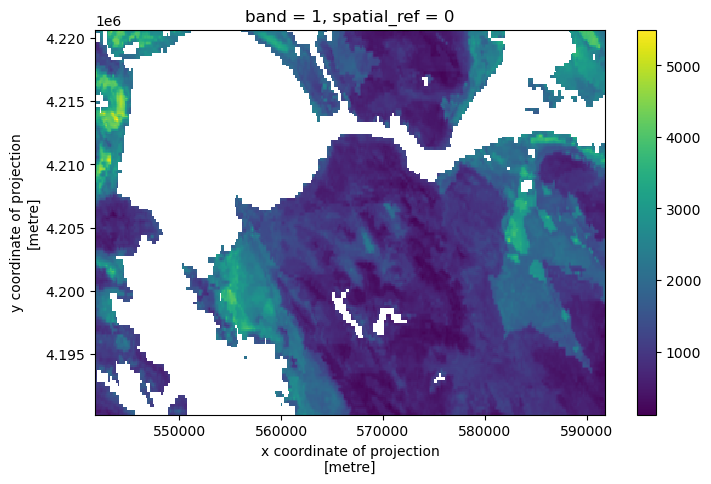

In [36]:
cropped_env_raster[0].plot.imshow(size=5,aspect=aspect_ratio)

# Patch Extractor Functional Usage

In [15]:
%load_ext autoreload

In [84]:
%autoreload 2
from environmental_raster import PatchExtractor

In [85]:
BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/rasters'
s3_raster_path = 's3://{}/{}/'.format(BUCKET_NAME, folder)

In [86]:
%%time
env_extractor = PatchExtractor(s3_raster_path, side_len_m=50000, out_dtype="uint8")
# env_extractor.append("bio_1")
# env_extractor.add_all_pedologic_rasters()
env_extractor.add_all_rasters()

Opening Raster file for  bio_1
Completed Setup of Raster bio_1 
Opening Raster file for  bio_2
Completed Setup of Raster bio_2 
Opening Raster file for  bio_3
Completed Setup of Raster bio_3 
Opening Raster file for  bio_4
Completed Setup of Raster bio_4 
Opening Raster file for  bio_5
Completed Setup of Raster bio_5 
Opening Raster file for  bio_6
Completed Setup of Raster bio_6 
Opening Raster file for  bio_7
Completed Setup of Raster bio_7 
Opening Raster file for  bio_8
Completed Setup of Raster bio_8 
Opening Raster file for  bio_9
Completed Setup of Raster bio_9 
Opening Raster file for  bio_10
Completed Setup of Raster bio_10 
Opening Raster file for  bio_11
Completed Setup of Raster bio_11 
Opening Raster file for  bio_12
Completed Setup of Raster bio_12 
Opening Raster file for  bio_13
Completed Setup of Raster bio_13 
Opening Raster file for  bio_14
Completed Setup of Raster bio_14 
Opening Raster file for  bio_15
Completed Setup of Raster bio_15 
Opening Raster file for  bio

In [83]:
import gc
del env_extractor
gc.collect()

1127

## Retrieve the patch

In [87]:
aoi_si.rio.crs

CRS.from_epsg(32610)

In [88]:
%%time

berkeley = (-122.24055786132824,37.90587960532352)
coordinates = (berkeley, aoi_si)
# coordinates = ((-124.36556, 40.23088), crs)
patch = env_extractor[coordinates]

torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 256]) <class 'torch.Tensor'>
torch.Size([1, 256, 

In [89]:
patch.shape

torch.Size([27, 256, 256])

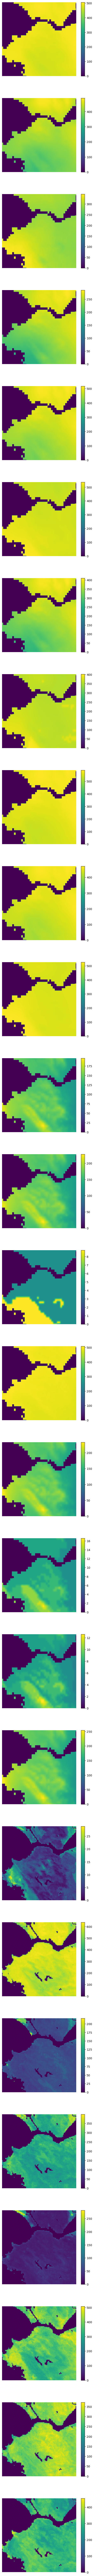

In [80]:
import matplotlib.pyplot as plt
side_len = 6
plt.figure(figsize=(side_len,patch.shape[0]*side_len))
plt.subplots_adjust(hspace=0.3)

# loop through the length of tickers and keep track of index
for i in range (0,patch.shape[0]):
    RGB_image = patch[i].unsqueeze(dim=0) * 3 #-> Remove first dim (channel) and then fake convert to RGB
    # add a new subplot iteratively
    ax = plt.subplot(patch.shape[0], 1, i + 1)
    shw = ax.imshow(RGB_image.permute(1, 2, 0))#, vmax=1.0)
    bar = plt.colorbar(shw)
    ax.axis('off')

In [71]:
patch.shape

torch.Size([8, 256, 256])

In [90]:
patch.max()

tensor(212.2493, dtype=torch.float64)

In [91]:
patch

tensor([[[  0.0000,   0.0000,   0.0000,  ..., 165.6343, 165.5544, 165.4745],
         [  0.0000,   0.0000,   0.0000,  ..., 165.6411, 165.5644, 165.4844],
         [  0.0000,   0.0000,   0.0000,  ..., 165.6502, 165.5777, 165.4981],
         ...,
         [  0.0000,   0.0000,   0.0000,  ..., 161.1253, 161.1747, 161.2120],
         [  0.0000,   0.0000,   0.0000,  ..., 160.9542, 161.0104, 161.0597],
         [  0.0000,   0.0000,   0.0000,  ..., 160.7834, 160.8457, 160.9072]],

        [[  0.0000,   0.0000,   0.0000,  ..., 145.3892, 144.9303, 144.4714],
         [  0.0000,   0.0000,   0.0000,  ..., 145.3707, 144.9422, 144.4959],
         [  0.0000,   0.0000,   0.0000,  ..., 145.3687, 144.9755, 144.5443],
         ...,
         [  0.0000,   0.0000,   0.0000,  ..., 133.1122, 133.1356, 133.1730],
         [  0.0000,   0.0000,   0.0000,  ..., 133.1356, 133.1373, 133.1433],
         [  0.0000,   0.0000,   0.0000,  ..., 133.1588, 133.1397, 133.1143]],

        [[  0.0000,   0.0000,   0.0000,  ...